## Understanding the data

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', None)

### Q:3 Discrepancies in active_mins: "number of minutes spent on site for the date" ?

In [2]:
exp = pd.read_csv('../datasets/t1_user_active_min.csv')  # during experiment
variant = pd.read_csv('../datasets/t2_user_variant.csv')  # variant info

In [3]:
print("no of cases:", len(exp))
exp.head()

no of cases: 1066402


,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [4]:
max_possible_mins = 24 * 60 #1440
weird_df = exp.loc[exp['active_mins'] > max_possible_mins, :]
weird_df.head()

,uid,dt,active_mins
26670,1219,2019-02-22,99999.0
38577,1738,2019-02-25,99999.0
53137,2398,2019-04-19,99999.0
69731,3124,2019-04-26,99999.0
69742,3124,2019-05-10,99999.0


In [5]:
weird_df.active_mins.value_counts()

99999.0    172
Name: active_mins, dtype: int64

In [6]:
exp.drop(index=weird_df.index, inplace=True)
print("Check: New length should be", 1066402 - 172)
print("Check: New length is", exp.shape[0])
exp.active_mins.describe()

Check: New length should be 1066230
Check: New length is 1066230


count    1.066230e+06
mean     2.004248e+01
std      4.653763e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      8.970000e+02
Name: active_mins, dtype: float64

## T-test & Confidence Interval

In [7]:
print("no of cases:", len(variant))
variant.head()

no of cases: 50000


,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


### Are some users in control and treatment groups same ?

In [8]:
variant.variant_number.value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

In [9]:
control_uid = variant.loc[variant.variant_number == 0, ['uid']]
treatment_uid = variant.loc[variant.variant_number == 1, ['uid']]
control_uid.describe()

,uid
count,40000.00000
mean,19999.50000
std,11547.14972
min,0.00000
25%,9999.75000
50%,19999.50000
75%,29999.25000
max,39999.00000


In [10]:
treatment_uid.describe()

,uid
count,10000.00000
mean,44999.50000
std,2886.89568
min,40000.00000
25%,42499.75000
50%,44999.50000
75%,47499.25000
max,49999.00000


### The above values for min and max of uid do not overlap, meaning that there are different set of users in both groups.

<AxesSubplot:>

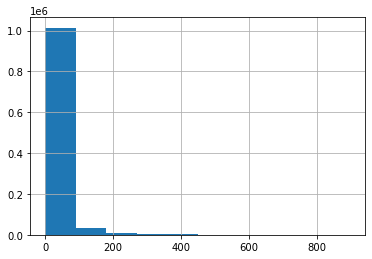

In [11]:
# trying to see if there are some extreme active minutes which might hamper authenticity of results as they might not even represent
# a population well by being such extreme outliers

exp.active_mins.hist()

### Looks like there are some really high values

<AxesSubplot:>

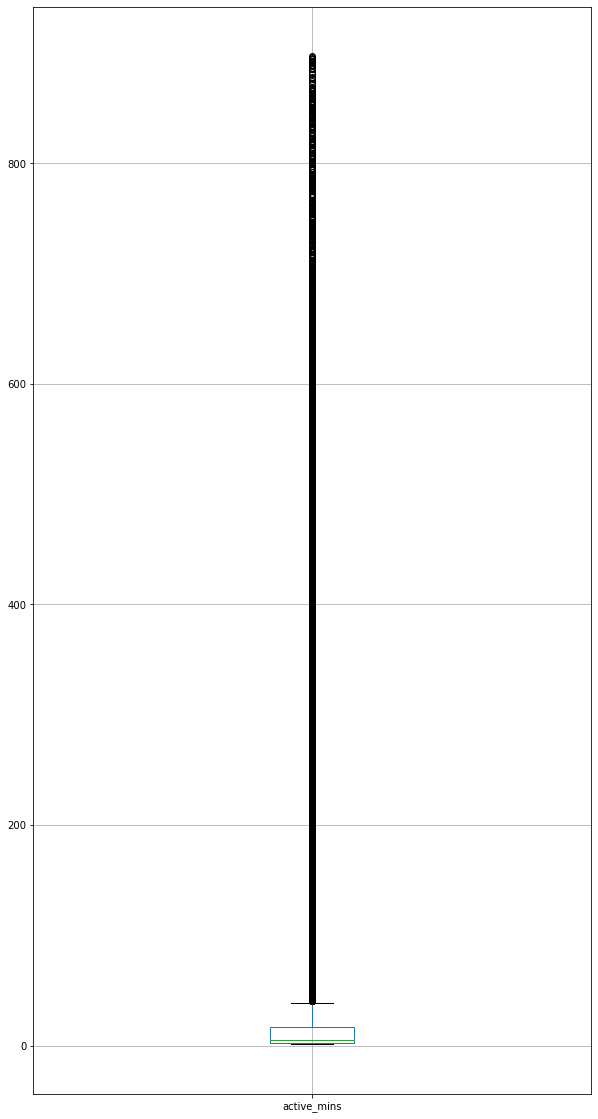

In [12]:
exp.boxplot(column='active_mins', figsize=(10, 20), grid=True)

In [13]:
exp.active_mins.describe()

count    1.066230e+06
mean     2.004248e+01
std      4.653763e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      8.970000e+02
Name: active_mins, dtype: float64

### 50 % data is within 2 and 17 minutes, I will take all data within the upper inner fence ( up to Q3 + 1.5IQR)

In [14]:
offset = exp.active_mins.quantile(0.75) + 1.5 * (exp.active_mins.quantile(0.75) - exp.active_mins.quantile(0.25))
print(offset)

39.5


<AxesSubplot:>

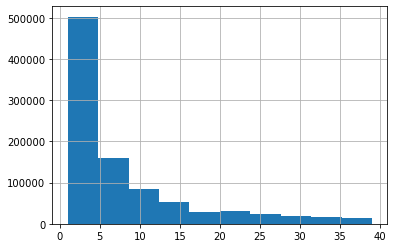

In [15]:
test_df = exp.loc[exp.active_mins <= offset]
test_df.active_mins.hist()

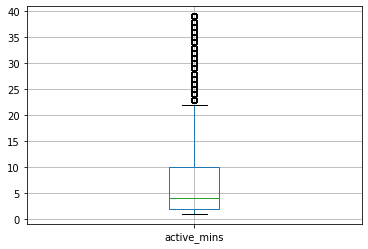

In [16]:
ax = test_df.boxplot(column='active_mins', grid=True)

In [17]:
print("Removed how much?")
exp.shape[0]-test_df.shape[0]

Removed how much?


134277

In [18]:
exp_final = test_df.copy()

In [19]:
# finding actual data points for t-test -> active minutes added per user

total_mins_per_user = exp_final.groupby(['uid']).agg({'dt': 'count', 'active_mins': 'mean'})
total_mins_per_user.head()

,dt,active_mins
uid,,
0,13,3.307692
1,5,19.800000
2,7,2.428571
3,24,3.208333
4,20,1.950000


In [20]:
# finding which user is in which group by merging 'total_mins_per_user' with 'variant' 
# (inner join is appropriate as we dont need variant info of people
# who never opened the site anyway)

df = total_mins_per_user.join(variant, how="inner", on="uid", lsuffix='left', rsuffix='right')
df.head()

,dtleft,active_mins,uid,variant_number,dtright,signup_date
uid,,,,,,
0,13,3.307692,0,0,2019-02-06,2018-09-24
1,5,19.800000,1,0,2019-02-06,2016-11-07
2,7,2.428571,2,0,2019-02-06,2018-09-17
3,24,3.208333,3,0,2019-02-06,2018-03-04
4,20,1.950000,4,0,2019-02-06,2017-03-09


Text(3.1999999999999993, 0.5, 'active minutes')

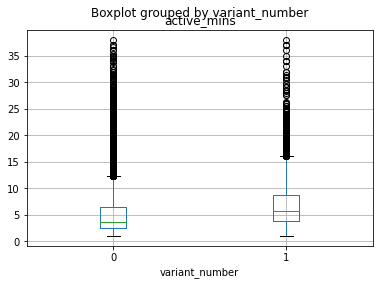

In [21]:
df.boxplot(column='active_mins', by='variant_number')
ax.set_ylabel('active minutes')

<AxesSubplot:>

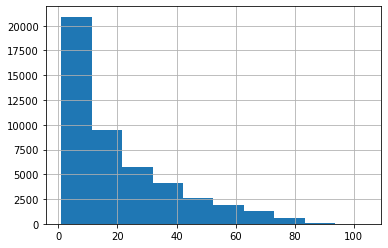

In [22]:
# histogram for total number of times logged in by user
df.dtleft.hist()

Text(0, 0.5, 'number of times logged in')

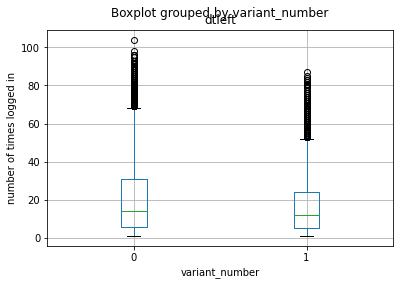

In [23]:
ax = df.boxplot(column='dtleft', by='variant_number')
ax.set_ylabel('number of times logged in')

### There are some people in control group who log in to Quora's OLD site more than 100 times overall, whereas the treatment group users who login many times(outliers) only do it around 90 times on NEW site. Also, treatment group users are more consistent (lesser IQR)

In [24]:
df_c = df.loc[df.variant_number == 0]
df_c.dtleft.describe()

count    37408.000000
mean        20.794777
std         19.272487
min          1.000000
25%          6.000000
50%         14.000000
75%         31.000000
max        104.000000
Name: dtleft, dtype: float64

In [25]:
df_t = df.loc[df.variant_number == 1]
df_t.loc[df.variant_number == 1].dtleft.describe()

count    9197.000000
mean       16.751332
std        15.412130
min         1.000000
25%         5.000000
50%        12.000000
75%        24.000000
max        87.000000
Name: dtleft, dtype: float64

In [26]:
# removing people beyond Q3 + 1.5 * IQR 
df_c = df_c.loc[df_c.dtleft < df_c.dtleft.quantile(0.75) + 1.5 * (df_c.dtleft.quantile(0.75)-df_c.dtleft.quantile(0.25))]
df_t = df_t.loc[df_t.dtleft < df_t.dtleft.quantile(0.75) + 1.5 * (df_t.dtleft.quantile(0.75)-df_t.dtleft.quantile(0.25))]

Text(0, 0.5, 'number of times logged in (removed outliers)')

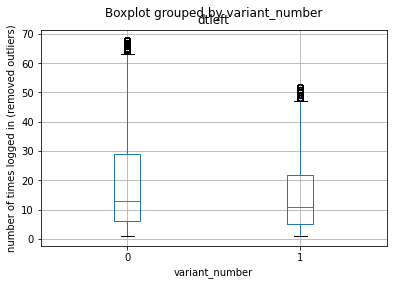

In [27]:
df_temp = df_c.append(df_t)
ax = df_temp.boxplot(column='dtleft', by='variant_number')
ax.set_ylabel('number of times logged in (removed outliers)')

### Do the two variant groups have equal sample size?

In [28]:
# people in control group
print("people in control group: ", df_c.shape)
# people in treatment group
print("people in treatment group: ", df_t.shape)

people in control group:  (36314, 6)
people in treatment group:  (8829, 6)


### There are more users in control group (4 times more) than treatment group, so using unequal variance Welch t-test is better than equal variance test 

### Just confirming that active_mins in both samples are kind of a mound shape distribution

<AxesSubplot:>

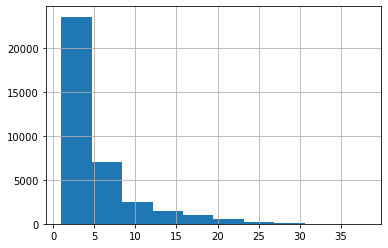

In [29]:
df_c.active_mins.hist()

<AxesSubplot:>

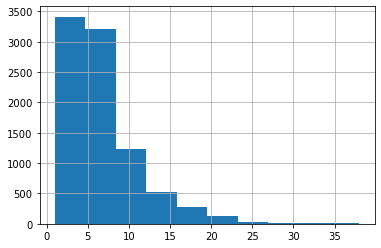

In [30]:
df_t.active_mins.hist()

Text(0, 0.5, 'active minutes')

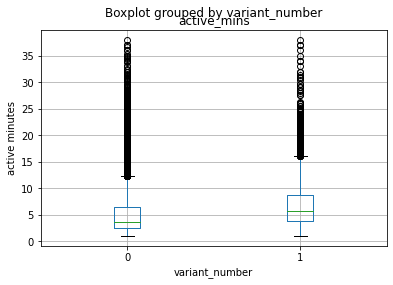

In [31]:
ax = df.boxplot(column='active_mins',by='variant_number')
ax.set_ylabel('active minutes')

## checking if variance is different for control and treatment groups

In [32]:
df_t.active_mins.std()

4.38302969957004

In [33]:
df_c.active_mins.std()

4.5135883682097315

## Though variances are similar, since the sample sizes are extremely different, I am taking welch test
## Ho = mean of entire control population = mean of entire experiment population
## Ha = there was a positive effect of new design and mean of control population < mean of experiment population

In [34]:
from scipy.stats import ttest_ind_from_stats
from scipy import stats

a = df_c.active_mins
b = df_t.active_mins

In [35]:
ttest_ind_from_stats(mean1=a.mean(),std1=a.std(),nobs1=a.count(),
                     mean2=b.mean(),std2=b.std(),nobs2=b.count(),
                     equal_var=False)

Ttest_indResult(statistic=-29.07069953011281, pvalue=2.2861357076571307e-180)

## Q:4 Lower bound, Q:5 Upper bound for CI

In [36]:
mu1 = a.mean()
mu2 = b.mean()
s1 = a.std()
s2 = b.std()
n1 = a.count()
n2 = b.count()
cl = 0.95
std_error = np.sqrt(((s1**2)/n1) + ((s2 ** 2) / n2))
t = stats.norm.isf((1-cl))  # 1 tailed 
lower = mu1 - mu2 - t*std_error
upper = mu1 - mu2 + t*std_error

print("CI:", np.round(lower, 2), np.round(upper, 2))  # since question asks to round of to two decimal place

CI: -1.61 -1.43


In [37]:
df_c.active_mins.mean()  ##lower than df_t mean

5.206948008009867

In [38]:
df_t.active_mins.mean()

6.7277932188584275

## Q:7

### p value is extremely small and we can say that there was an effect of the new design on the users. Even the confidence interval doesnt have a 0 inside it. Ideally, we should research more as this comparison doesn't make sense. The users in both groups are different. User T in treatment might have gone from 30 minutes on old site to 20 minutes on new site but User C in control group could be spending 15 minutes on the old site. Instead of seeing the decreasing change from 30 to 20, this t-test ends up focusing on the irrelevant difference between 20 and 15.

## Q:9 Use active minutes of a user before experiment

In [39]:
# find outliers, get rid of them
# find how long have people been monitored, get rid if too long or too less
# find people who continued to participate after experiment began (inner join)
# merge pre with variant
# make joint df for common people
# average data for each user for all days

pre = pd.read_csv('../datasets/t3_user_active_min_pre.csv')  # active minutes before the experiment began
pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


<AxesSubplot:>

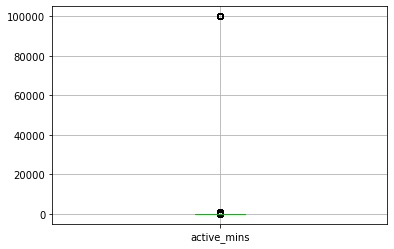

In [40]:
pre.boxplot(column='active_mins')

In [41]:
pre.drop(index=pre.loc[pre.active_mins > 24*60].index, inplace=True)
pre.active_mins.describe()

count    1.189927e+06
mean     1.825735e+01
std      4.354546e+01
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.400000e+01
max      8.970000e+02
Name: active_mins, dtype: float64

Offset:  32.0


<AxesSubplot:>

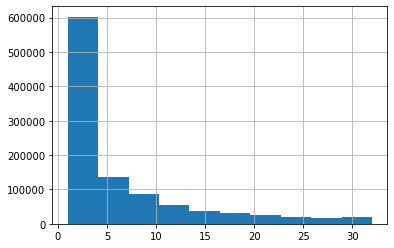

In [42]:
# Q3 + 1.5 * IQR
offset = pre.active_mins.quantile(0.75) + 1.5 * (pre.active_mins.quantile(0.75) - pre.active_mins.quantile(0.25))
print("Offset: ", offset)
pre = pre.loc[pre.active_mins <= offset]
pre.active_mins.hist()

## finding if people have spent similar time before and after experiment, so that the comparision is fair

In [43]:
print("Pre date min, max:", pre.dt.min(), pre.dt.max())
print("After date min, max:", exp_final.dt.min(), exp_final.dt.max())

Pre date min, max: 2018-08-10 2019-02-05
After date min, max: 2019-02-06 2019-07-05


Pre experiment period looks like 6 months long, Experiment period looks like 5 months long. For a decent first level analysis, we can go ahead with data as it is. With more time on hand, I would take away people with who have signed up more than 5 months before from both pre and during experiment data, for a better comparision.

In [44]:
# averaging total mins per user before/after experiment
pre_avg = pre.groupby(['uid']).agg({'dt': 'count', 'active_mins': 'mean'})
post_avg = total_mins_per_user

# merging pre and post data
# getting rid of people who were not in either pre or post experiment, for relevant comparision by inner join
df1 = pre_avg.join(post_avg, how="inner", on="uid", lsuffix='_pre', rsuffix='_post')
df1.head()

,dt_pre,active_mins_pre,dt_post,active_mins_post
uid,,,,
0,21,3.333333,13,3.307692
1,11,22.272727,5,19.800000
2,10,3.700000,7,2.428571
3,18,3.833333,24,3.208333
4,28,2.357143,20,1.950000


In [45]:
# merging with variant info
cols = ['dt_pre', 'dt_post', 'active_mins_pre', 'active_mins_post', 'variant_number']
df2 = df1.join(variant, how="inner", on="uid", rsuffix='v').loc[:,cols]
df2.head()

,dt_pre,dt_post,active_mins_pre,active_mins_post,variant_number
uid,,,,,
0,21,13,3.333333,3.307692,0
1,11,5,22.272727,19.800000,0
2,10,7,3.700000,2.428571,0
3,18,24,3.833333,3.208333,0
4,28,20,2.357143,1.950000,0


## Now I will perform paired t-test since people are same in pre/post the experiment. I will perform the test first for treatment group and then for control group separately.

In [46]:
df2['active_mins_diff'] = df2['active_mins_post'] - df2['active_mins_pre']
df2.head()

,dt_pre,dt_post,active_mins_pre,active_mins_post,variant_number,active_mins_diff
uid,,,,,,
0,21,13,3.333333,3.307692,0,-0.025641
1,11,5,22.272727,19.800000,0,-2.472727
2,10,7,3.700000,2.428571,0,-1.271429
3,18,24,3.833333,3.208333,0,-0.625000
4,28,20,2.357143,1.950000,0,-0.407143


In [47]:
test_t = df2.loc[df2.variant_number == 1]
test_c = df2.loc[df2.variant_number == 0]

In [48]:
test_t.describe().loc[['mean', 'max'],['active_mins_pre', 'active_mins_post']]

,active_mins_pre,active_mins_post
mean,4.870482,6.924268
max,29.000000,38.000000


In [49]:
test_c.describe().loc[['mean', 'max'],['active_mins_pre', 'active_mins_post']]

,active_mins_pre,active_mins_post
mean,5.184737,5.368229
max,31.000000,38.000000


## Looks like treatment group actually had an increase in mean whereas for control group a very slight increase. We will verify by paired t test and confidence intervals
 ### Ho = pre and post experiment means are equal
  ### Ha = pre experiment mean < post experiment mean

In [50]:
from scipy.stats import ttest_rel

# for treatment group
print("Treatment group:")
print(ttest_rel(test_t.active_mins_pre, test_t.active_mins_post, alternative='less'))

# for control group
print("Control group:")
print(ttest_rel(test_c.active_mins_pre, test_c.active_mins_post, alternative='less'))

Treatment group:
Ttest_relResult(statistic=-55.61309501616391, pvalue=0.0)
Control group:
Ttest_relResult(statistic=-11.96704150080547, pvalue=3.038748535774954e-33)


## Paired t test shows that we can reject Ho for treatment group, and post experiment mean > pre experiment mean

## Confidence interval for treatment effect

In [51]:
import math

def CI_paired(pre, post, diff):
    d_ = post.mean() - pre.mean()
    sd = diff.std() # standard deviation of difference of each pair, pre and post experiment
    n = pre.shape[0]

    std_error = sd/math.sqrt(n)
    lb = d_ - (1.65 * std_error)  #z value for one-sided confidence level of 95%
    ub = d_ + (1.65 * std_error)

    return (np.round(lb, 2), np.round(ub, 2))

In [52]:
print(f"CI treatment group: ", CI_paired(test_t.active_mins_pre, test_t.active_mins_post, test_t.active_mins_diff))
print(f"CI treatment group: ", CI_paired(test_c.active_mins_pre, test_c.active_mins_post, test_c.active_mins_diff))

CI treatment group:  (1.99, 2.11)
CI treatment group:  (0.16, 0.21)


## Since there is no zero in the CI, we can reject Ho and we can now be sure that there was actually an increase in active mins post experiment. I will report CI for treatment group for the answer.

# Q: 13 Adding another table and covariates, searching for any confounding (lurking) variables which contradict our analysis

In [53]:
attr = pd.read_csv('../datasets/t4_user_attributes.csv')
attr.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [54]:
cols = ['uid', 'dt', 'active_mins', 'variant_number']
df_ = pre.join(variant, how="inner", on="uid", rsuffix='v').loc[:,cols]
attr_pre = df_.join(attr, how="inner", on="uid", rsuffix='_attr').drop(columns=['uid_attr'])
attr_pre.head()

,uid,dt,active_mins,variant_number,gender,user_type
0,0,2018-09-24,3.0,0,male,non_reader
1,0,2018-11-08,4.0,0,male,non_reader
2,0,2018-11-24,3.0,0,male,non_reader
3,0,2018-11-28,6.0,0,male,non_reader
4,0,2018-12-02,6.0,0,male,non_reader


In [55]:
cols = ['uid', 'dt', 'active_mins', 'variant_number']
df_ = exp_final.join(variant, how="inner", on="uid", rsuffix='v').loc[:,cols]
attr_post = df_.join(attr, how="inner", on="uid", rsuffix='_attr').drop(columns=['uid_attr'])
attr_post.head()

,uid,dt,active_mins,variant_number,gender,user_type
0,0,2019-02-22,5.0,0,male,non_reader
1,0,2019-03-11,5.0,0,male,non_reader
2,0,2019-03-18,3.0,0,male,non_reader
3,0,2019-03-22,4.0,0,male,non_reader
4,0,2019-04-03,9.0,0,male,non_reader


## Number of people by gender and user type before experiment

In [56]:
attr_pre.groupby(['uid', 'variant_number', 'gender', 'user_type'], as_index=False).agg({'active_mins': 'mean'}).groupby(['variant_number', 'user_type']).agg({'uid': 'count', 'active_mins': 'mean'})

uid  active_mins
variant_number user_type                      
0              contributor    907    12.020206
               new_user      3478     4.168943
               non_reader   28623     3.947577
               reader        6726     9.664412
1              contributor    128    11.021809
               new_user      1165     4.343940
               non_reader    7350     4.024864
               reader        1267     9.232935

In [57]:
attr_pre.groupby(['uid', 'variant_number', 'gender', 'user_type'], as_index=False).agg({'active_mins': 'mean'}).groupby(['variant_number', 'user_type', 'gender']).agg({'uid': 'count', 'active_mins': 'mean'})

uid  active_mins
variant_number user_type   gender                     
0              contributor female     223    10.983409
                           male       588    12.496295
                           unknown     96    11.512548
               new_user    female    1106     3.951703
                           male      1673     4.316099
                           unknown    699     4.160467
               non_reader  female    8363     3.840001
                           male     15725     4.009185
                           unknown   4535     3.932334
               reader      female    1819     9.258702
                           male      4122     9.876762
                           unknown    785     9.489482
1              contributor female      26    10.586267
                           male        82    11.526876
                           unknown     20     9.517239
               new_user    female     385     4.514348
                           male       550     4.230909
                           unknown    230     4.328986
               non_reader  female    2087     3.863104
                           male      4100     4.094142
                           unknown   1163     4.070913
               reader      female     336     9.099160
                           male       752     9.323737
                           unknown    179     9.102574

## Number of people by gender and user type after experiment

In [58]:
attr_post.groupby(['uid', 'variant_number', 'gender', 'user_type'], as_index=False).agg({'active_mins': 'mean'}).groupby(['variant_number', 'user_type']).agg({'uid': 'count', 'active_mins': 'mean'})

uid  active_mins
variant_number user_type                      
0              contributor    903    14.329884
               new_user      2372     3.134401
               non_reader   27454     3.941514
               reader        6679    10.810775
1              contributor    126    13.545419
               new_user       807     5.425513
               non_reader    7008     5.976151
               reader        1256    12.458016

In [59]:
attr_post.groupby(['uid', 'variant_number', 'gender', 'user_type'], as_index=False).agg({'active_mins': 'mean'}).groupby(['variant_number', 'user_type', 'gender']).agg({'uid': 'count', 'active_mins': 'mean'})

uid  active_mins
variant_number user_type   gender                     
0              contributor female     222    12.369391
                           male       586    15.245286
                           unknown     95    13.264665
               new_user    female     762     3.069377
                           male      1133     3.224292
                           unknown    477     3.024762
               non_reader  female    7937     3.820953
                           male     15186     4.023706
                           unknown   4331     3.874265
               reader      female    1812    10.343886
                           male      4089    11.110354
                           unknown    778    10.323660
1              contributor female      26    13.005459
                           male        81    14.211443
                           unknown     19    11.444946
               new_user    female     275     5.242303
                           male       376     5.499319
                           unknown    156     5.570586
               non_reader  female    1974     5.796804
                           male      3927     6.106726
                           unknown   1107     5.832759
               reader      female     333    11.866491
                           male       747    12.723727
                           unknown    176    12.449441

## Possible issue: Looks like males are greater part of this analysis, and non readers are also huge as compared to others which can create bias in test and not lead to correct analysis when the new site is in production.

## Also, Looks like contributors has a higher average activity time than others. New users are almost similar to non readers.
## Also, after experiment begins, contributors are spending similar average time irrespective of variant group, but non readers and new users are spending more average time in treatment group.

In [60]:
print("before experiment began, # of males: " ,attr_pre.loc[attr_pre.gender == 'male'].groupby('uid').count().shape)
print("before experiment began, total: " ,attr_pre.groupby('uid').count().shape)

print("post experiment, # of males: " ,attr_post.loc[attr_post.gender == 'male'].groupby('uid').count().shape)
print("post experiment began, total: " ,attr_post.groupby('uid').count().shape)

before experiment began, # of males:  (27592, 5)
before experiment began, total:  (49644, 5)
post experiment, # of males:  (26125, 5)
post experiment began, total:  (46605, 5)


In [61]:
print("before experiment began, # of non readers: " ,attr_pre.loc[attr_pre.user_type == 'non_reader'].groupby('uid').count().shape)
print("before experiment began, total: " ,attr_pre.groupby('uid').count().shape)

print("post experiment, # of non readers: " ,attr_post.loc[attr_post.user_type == 'non_reader'].groupby('uid').count().shape)
print("post experiment began, total: " ,attr_post.groupby('uid').count().shape)

before experiment began, # of non readers:  (35973, 5)
before experiment began, total:  (49644, 5)
post experiment, # of non readers:  (34462, 5)
post experiment began, total:  (46605, 5)


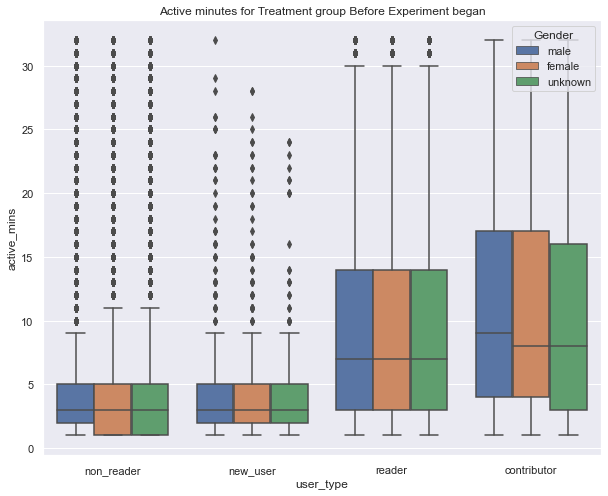

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10, 8)})
sns.boxplot(x='user_type', y='active_mins', data=attr_pre.loc[attr_pre.variant_number == 1], hue='gender')
plt.title('Active minutes for Treatment group Before Experiment began')
plt.legend(loc='upper right', title='Gender')

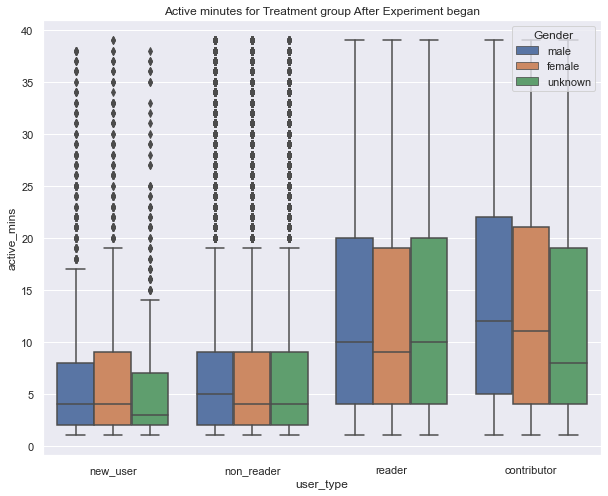

In [63]:
sns.boxplot(x='user_type', y='active_mins', data=attr_post.loc[attr_post.variant_number == 1], hue='gender')
plt.title('Active minutes for Treatment group After Experiment began')
plt.legend(loc='upper right', title='Gender')

## Overall in treatment group:
### New Users, Non Readers: the average new user population read less than 5 minutes before, but we see the median approaching 5 minutes after experiment began. Especially females have shown an increase for new users. A non outlier female new user time reached less than 10 minutes earlier, but now it is approaching 20 minutes. Similarly for non readers, (12 to 20) 

### Readers: 75% readers were spending less than 15 minutes earlier with median mark way below 10 minutes, but now ~67th - 75th percentile  people are above 15 minutes with median at 10 minute mark. Also, earlier only outliers were above 30 minutes, but now non outlier people are approaching 40 minutes.

### Contributors: Show less sensitivity towards the new design. But they do show overall population median shifting above 10.

## To check if this is not by chance we will see what's happening with control group

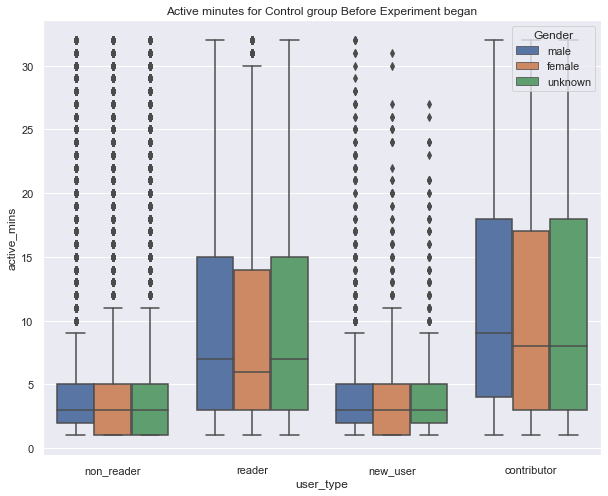

In [64]:
sns.boxplot(x='user_type', y='active_mins', data=attr_pre.loc[attr_pre.variant_number == 0], hue='gender')
plt.title('Active minutes for Control group Before Experiment began')
plt.legend(loc='upper right', title='Gender')

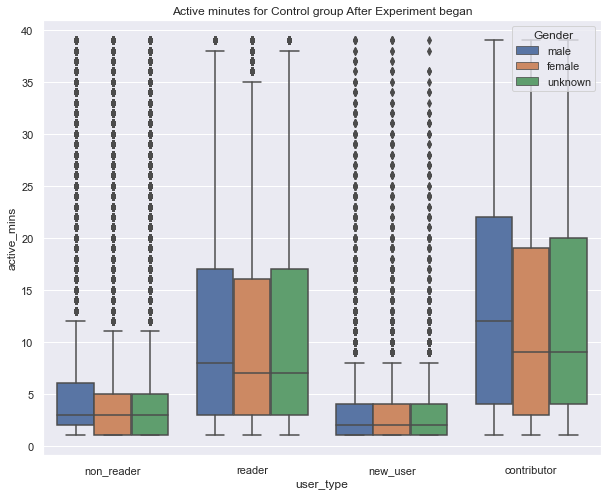

In [65]:
sns.boxplot(x='user_type', y='active_mins', data=attr_post.loc[attr_post.variant_number == 0], hue='gender')
plt.title('Active minutes for Control group After Experiment began')
plt.legend(loc='upper right', title='Gender')

## Non readers, readers, new users average reading times are essentially unchanged before, after experiment. Contributors seem to increase activity though, but since that happens in treatment population too, we can assume that overall contributor population changed reading habits in the months when experiment was done, not just treatment group.

## This implies there was an increase in treatment groups' reading times as a response to the new design not by chance. 

In [66]:
# this df contains active minutes added day wise for different user types, from first day before experiment began
# to the last day after the experiment began.

day_df_pre = attr_pre.groupby(['variant_number','dt','user_type'], as_index=False).agg({'active_mins': 'mean'})
day_df_post = attr_post.groupby(['variant_number','dt','user_type'], as_index=False).agg({'active_mins': 'mean'})
day_df = day_df_pre.append(day_df_post)
day_df.head()

,variant_number,dt,user_type,active_mins
0,0,2018-08-10,contributor,10.339744
1,0,2018-08-10,non_reader,4.754364
2,0,2018-08-10,reader,9.614126
3,0,2018-08-11,contributor,11.622754
4,0,2018-08-11,non_reader,4.960809


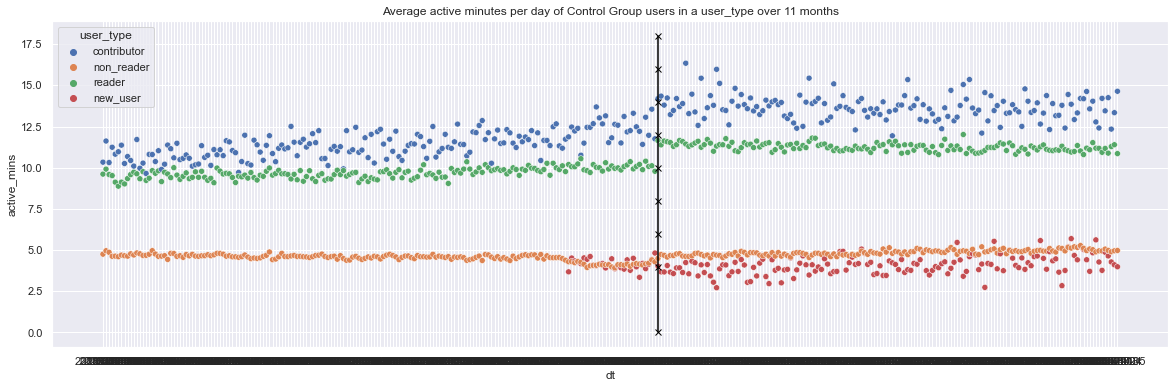

In [67]:
sns.set(rc={'figure.figsize':(20, 6)})
day_df_c = day_df.loc[day_df.variant_number == 0]
sns.scatterplot(x='dt', y='active_mins', hue='user_type', data=day_df_c)
plt.plot(['2019-02-06']* 9, [0,4,6,8,10,12,14,16,18], marker='x', color='black') ## experiment begins
plt.title('Average active minutes per day of Control Group users in a user_type over 11 months')
plt.savefig('Control_group_usertype.png')

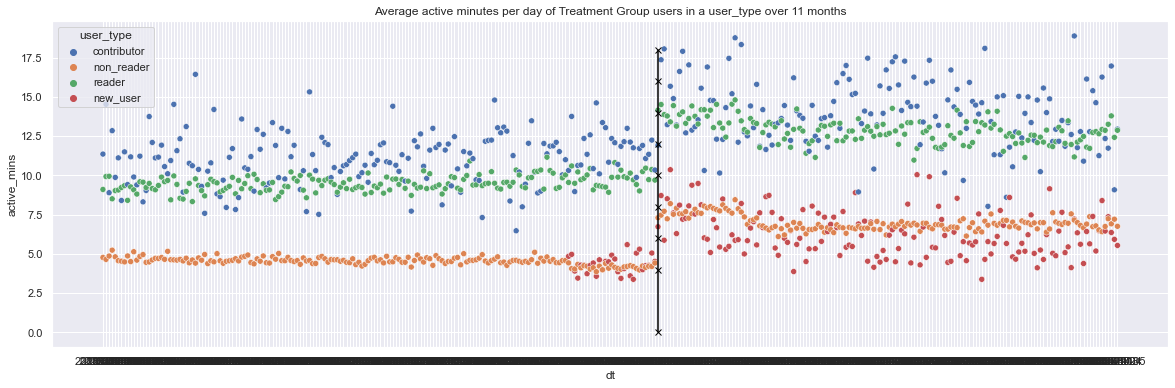

In [68]:
day_df_t = day_df.loc[day_df.variant_number == 1]
sns.scatterplot(x='dt', y='active_mins', hue='user_type', data=day_df_t)
plt.plot(['2019-02-06']* 9, [0,4,6,8,10,12,14,16,18], marker='x', color='black') ## experiment begins
plt.title('Average active minutes per day of Treatment Group users in a user_type over 11 months')
plt.savefig('Treatment_group_user_type')

## Wait what's wrong with new users (in red)?

In [69]:
print("First new user in control group:", min(day_df_c.loc[day_df_c.user_type=='new_user'].dt))
print("First new user in treatment group:", min(day_df_t.loc[day_df_t.user_type=='new_user'].dt))

First new user in control group: 2019-01-08
First new user in treatment group: 2019-01-08


## Looks like new users came into the system pretty late. Already somewhere near January, and we do not have enough data on what there reading habits were before experiment began (what if it was higher before?). Therefore, an increase in treatment group new users is not reliable.

## There is a spike for all user types when experiment begins for treatment groups. And a tiny spike for reader group in control group too! Contributor group in control group seems to increase steadily anyway. But then with time this increase again decreasing => either people get bored with new design too or they showed increased activity because they had trouble navigating the new site.

# Let's see for gender (I added minutes instead of average to see stark difference due to the high number of males we noticed earlier!)

In [70]:
gen_df_pre = attr_pre.groupby(['variant_number','dt','gender'], as_index=False).agg({'active_mins': 'sum'})
gen_df_post = attr_post.groupby(['variant_number','dt','gender'], as_index=False).agg({'active_mins': 'sum'})
gen_df = gen_df_pre.append(gen_df_post)
gen_df.head()

,variant_number,dt,gender,active_mins
0,0,2018-08-10,female,6040.0
1,0,2018-08-10,male,16968.0
2,0,2018-08-10,unknown,2975.0
3,0,2018-08-11,female,5947.0
4,0,2018-08-11,male,17913.0


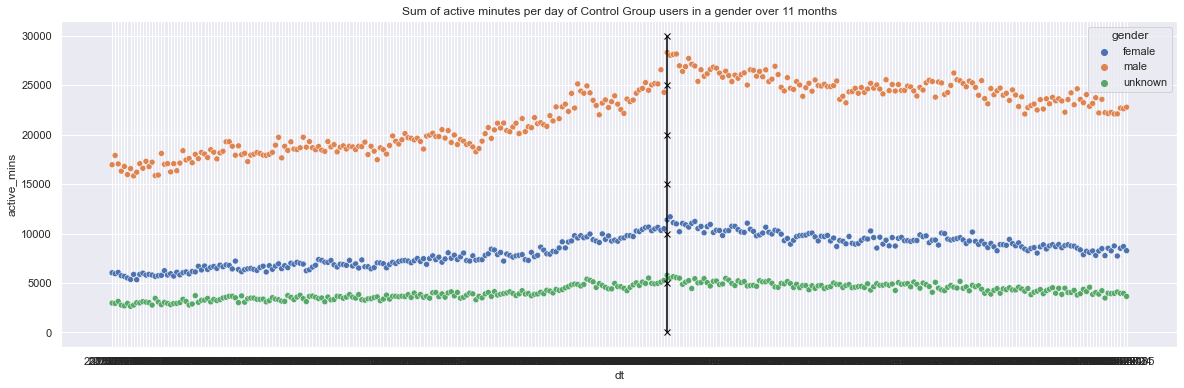

In [71]:
gen_df_c = gen_df.loc[gen_df.variant_number == 0]
sns.scatterplot(x='dt', y='active_mins', hue='gender', data=gen_df_c)
plt.plot(['2019-02-06']* 7, [5000*i for i in range(7)], marker='x', color='black') ## experiment begins
plt.title('Sum of active minutes per day of Control Group users in a gender over 11 months')
plt.savefig('Control_group_gender')

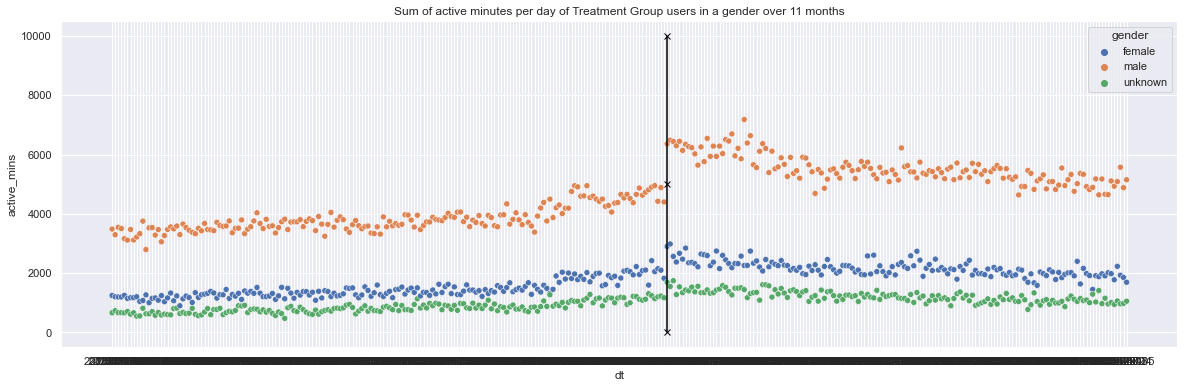

In [72]:
gen_df_t = gen_df.loc[gen_df.variant_number == 1]
sns.scatterplot(x='dt', y='active_mins', hue='gender', data=gen_df_t)
plt.plot(['2019-02-06']* 3, [5000*i for i in range(3)], marker='x', color='black') ## experiment begins
plt.title('Sum of active minutes per day of Treatment Group users in a gender over 11 months')
plt.savefig('Treatment_group_gender')

## Females seem to double the total number of active minutes per day from ~1000 in Aug 2018 to sudden increase to ~3000 when experiment began and then decrease to ~2000 by July 2019 (I would have said that maybe they got bored of even this new design by July, but the decrease trend exists even for control group and even for males, so there is probably another lurking variable leading to this decrease). 

## Unknown population remains same. 

## Males go from ~3750 to ~6000 active minutes when experiment began, then decrease to ~5000 by July (but males show similar trend even in control group, hence considering the UI design the cause of this increase is doubtful.)